## Gradient descent method

$x \in \mathbb{R}^n$에 대한 unconstrained optimization problem이 있습니다.
$$ minimize\,\,f(x) = -\sum_{i=1}^m \log(1 - a_i^T x) - \sum_{i=1}^n \log(1 - x_i^2) $$

Q1. $\mathbf{dom} f$를 구하세요. function $f$는 closed인가요? 그 이유를 설명해 주세요.

$$ \mathbf {dom}f = \{x~|~a_i^Tx \lt 1,~i=1,...,m,~|x_i| \lt 1, ~i=1,...,n \}~\text{is open} $$  

$$ \text{Since}~ f(x) \rightarrow \infty ~\text{as}~ x  ~\text{approaches the boundary of}~  \mathbf{dom}f,~f ~\text{is closed} $$

Q2. problem size $m = 200, n = 100,$ parameter $\alpha = 0.01, \beta = 0.5$에 대해 backtracking 방법으로 step size를 계산하고, gradient descent를 구현하세요. 이때 초기값 $x^{(0)} = 0$으로 설정하고, $\lVert \nabla f(x) \rVert_2 \leq 10^{-3}$을 stopping criterion으로 설정하세요. $f(x^{(k)}) - p^*$와 step size의 plot을 그려 확인해 보세요.

In [1]:
# Convex 패키지로 optimal value p* 구하기. 
using Random
using Convex, SCS
Random.seed!(20231)

m = 200;
n = 100;
A = randn(m, n)

x = Variable(n)
obj = -sum(log(1 - A*x)) - sum(log(1 + x)) - sum(log(1 - x))

problem = minimize(obj)
solve!(problem, SCS.Optimizer; silent_solver=true)
pstar = evaluate(obj)

-159.38581054892282

In [2]:
using LinearAlgebra

# Backtraking line search parameters
α = 0.01
β = 0.5

maxiter = 1000 # 혹시나 이만큼 반복해도 수렴하지 않으면 잘못 작성한 것입니다.
η = 1e-3 # stopping criterion

# problem size
m = 200 
n = 100

# gradient method. 이쪽 빈칸은 위쪽 블럭과 달리 "." 사용에 주의해서 작성해야 합니다.
vals = []
steps = []
x = zeros(n, 1)
for iter = 1:maxiter
    val = -sum(log.(1 .- A*x)) - sum(log.(1 .+ x)) - sum(log.(1 .- x)) #현재 x값에서의 objective value
    push!(vals, val) #vals.append(val)

    grad = A'*(1 ./ (1 .- A*x)) - (1 ./ (1 .+ x))+ (1 ./ (1 .- x))# chain rule을 활용해 gradient를 도출하세요.
    v = -grad # gradient method에서 사용하는 direction을 쓰세요.
    fprime = grad' * v # backtracking line search에서 사용하는 f의 first order approximation을 쓰세요.
    println(norm(grad)) #진행 과정을 보여주기 위해 norm(f)를 쭉 프린트해 줍니다.
        
    # stopping criterion
    if norm(grad) < η 
        break
    end
    
    t = 1
    while ((maximum(A*(x+t*v)) >= 1) || (maximum(abs.(x+t*v)) >= 1)) # x + t*Delta x)가 function domain에 포함되지 않는 조건을 작성하세요. (domain에 포함될 때까지 t를 줄인다는 동작입니다.)
    t = β*t
    end
    while ( -sum(log.(1 .- A*(x+t*v))) - sum(log.(1 .- (x+t*v).^2)) > val + α*t*fprime[1] ) # f(x + t*Delta x) > f(x) + alpha * t * fprime 인 조건을 작성하세요. (반대가 성립할 때까지 t를 줄인다는 동작입니다.)
    t = β*t
    end
    x = x+t*v #update x
    push!(steps, t)
end


154.33978314406096
153.3260706422048
88.7138064047687
62.69804607012168
253.2517234261679
64.9271204520326
74.8403889675014
62.40767528417434
45.73654493950776
117.48359756985555
52.05751272674438
126.70274316267877
51.82883339183187
35.39061980096671
41.68822766183497
106.20926793030193
43.251713350885545
30.448332320551085
63.43687356931055
45.53584987079956
35.95003833017742
36.12703682180045
33.15660421392888
27.30098853263126
54.94274473389078
59.276901218074094
26.054704511071165
20.213454294821556
57.384872917646916
50.51019727446834
41.10820784784076
27.93498425584981
25.23237556257517
23.182676875159235
22.886308965343304
23.31030179916929
23.34815338368728
23.60744131955675
23.701174678202396
24.03804655438497
24.117861398238436
24.322468352282975
24.378283192217886
24.533078685442046
24.56732538169344
24.663371370251554
24.684048087949915
24.755891160262205
10.994302010066617
33.763900420469206
15.12204908501866
15.81892233853558
16.74606670465069
18.821560029520604
19.76263

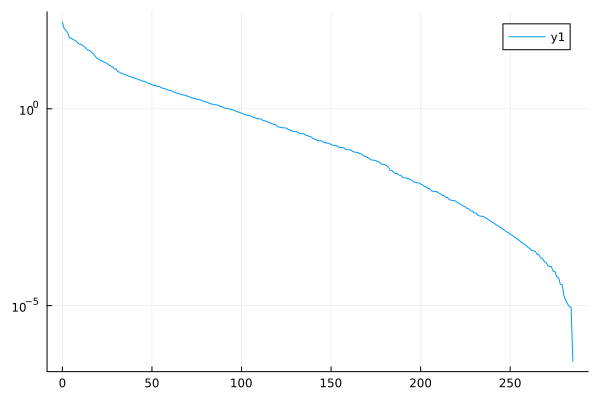

In [3]:
using Plots
gap = vals .- pstar
y = gap[gap .> 0]
x = [0:length(y)-1]
plot(x, y, yaxis =:log) 

#=
gap은 log scale plot에서 linear하게 감소합니다. 다만 앞에서 Convex 패키지로 구한 값이 아주 정확한 값은 아니므로 gap이 음수인 부분이 생기며,
마지막에 약간 비정상적인 패턴이 보입니다.
=#

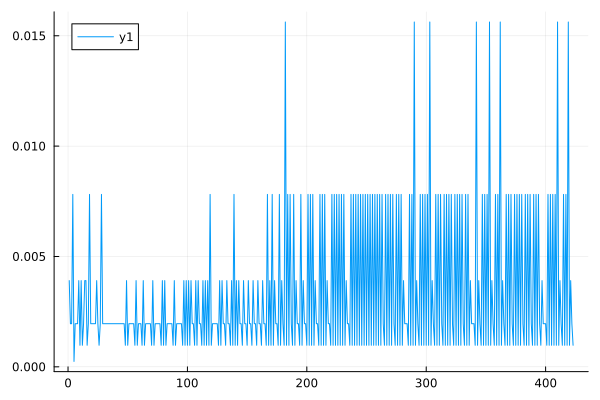

In [4]:
plot([1:length(steps)], steps)

아래는 참고용으로 써 놓은 Newton method의 코드입니다.

In [5]:
# Newton method 
ϵ = 1e-8

vals2 = [] 
steps2 = []
x = zeros(n,1)
for iter = 1:maxiter
    val = -sum(log.(1 .- A*x)) - sum(log.(1 .+ x)) - sum(log.(1 .- x))
    push!(vals2, val)
    d=1 ./ (1 .- A * x)
    grad = A'* d - (1 ./ (1 .+ x))+ (1 ./ (1 .- x))
    hess = A'*Diagonal(dropdims(d.^2, dims=2))*A + Diagonal(dropdims((1 ./ (1 .+ x).^2) + (1 ./ (1 .- x).^2), dims=2))
    v = -hess\grad
    fprime = grad' * v
    if abs(fprime[1]) < ϵ 
        break 
    end
    t = 1
    while ((maximum(A*(x+t*v)) >= 1) || (maximum(abs.(x+t*v)) >= 1))
    t = β*t
    end
    while ( -sum(log.(1 .- A*(x+t*v))) - sum(log.(1 .- (x+t*v).^2)) > val + α*t*fprime[1] )
    t = β*t
    end
    x = x+t*v
    push!(steps2, t)
end

In [6]:
vals2 .- pstar #수렴이 훨씬 빠른 것을 확인해 볼 수 있습니다. 역시 Convex 패키지로 구한 값이 부정확하므로 gap이 음수인 부분이 생깁니다.

8-element Vector{Float64}:
 159.38581054892282
  84.37460138736311
  20.393861617167914
   5.692929702557706
   0.22939564504252985
   0.007809379860191257
  -7.535514245660124e-5
  -0.00011110656086543713

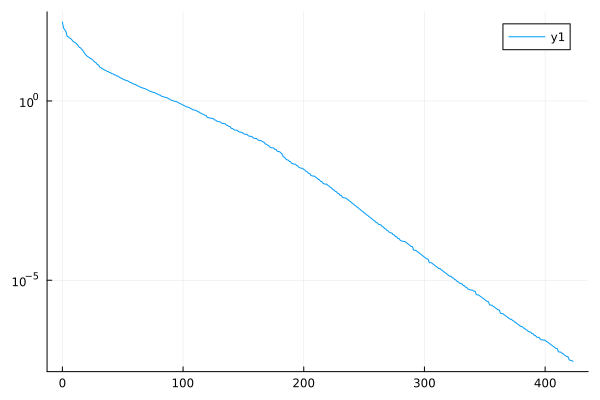

In [7]:
# newton method로 구한 값이 패키지보다 정확한 값이므로, 그 값을 optimal value로 설정해 아까의 그래프를 다시 그리면 정상적인 패턴이 나옵니다.
optval = vals2[end]
gap = vals .- optval
y = gap
x = [0:length(y)-1]
plot(x, y, yaxis =:log) 